In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, f1_score

N_DATA = 200

In [7]:
# helper_funcs 
def calculate_agreement(model_labels, pos_neg=None, maj_vote=maj_vote):
    if pos_neg == None:
        agreement = [int(i == j) for i, j in zip(model_labels, maj_vote)]
        return agreement, np.mean(agreement), len(agreement)
    elif pos_neg == 1:
        agreement = [int(i == j) for i, j in zip(model_labels, maj_vote) if j == 1]
        return agreement, np.mean(agreement), len(agreement)
    elif pos_neg == 0:
        agreement = [int(i == j) for i, j in zip(model_labels, maj_vote) if j == 0]
        print(len(agreement))
        return agreement, np.mean(agreement), len(agreement)
    
def bootstrap_se(data, n_bootstrap=1000):
    means = []
    n = len(data)
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        means.append(np.mean(sample))
    return np.std(means)

def compute_roc_auc(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)
    return fpr, tpr, roc_auc

In [155]:
mutual_information = json.load(open("data/mutual_information/v2/human_assistant_instruct_0_5000_4_17.json", "r"))
mutual_information = [v["mutual_information"] for v in mutual_information.values()][:200]
# mutual_information = json.load(open("data/expected_info_gain/hai_start_0_end_200_n_user_2_seed_0_12.json", "r"))
# mutual_information = [np.mean(v["question_performances"][2:]) for v in mutual_information.values()]
llama_labels = json.load(open("data/labels/llama_0_200_answer_first.json", "r"))
gpt4_labels = json.load(open("data/labels/gpt4_0_200_answer_first.json", "r"))["label"]
maj_vote = json.load(open("data/labels/exp_when_9_pp_maj_votes_0_200.json", "r"))
mean_vote = json.load(open("data/labels/exp_when_9_pp_mean_votes_0_200.json", "r"))


In [158]:
norm_mi = (np.array(mutual_information) - np.mean(mutual_information)) / np.std(mutual_information)
norm_mean_vote = (np.array(mean_vote) - np.mean(mean_vote)) / np.std(mean_vote)


<BarContainer object of 20 artists>

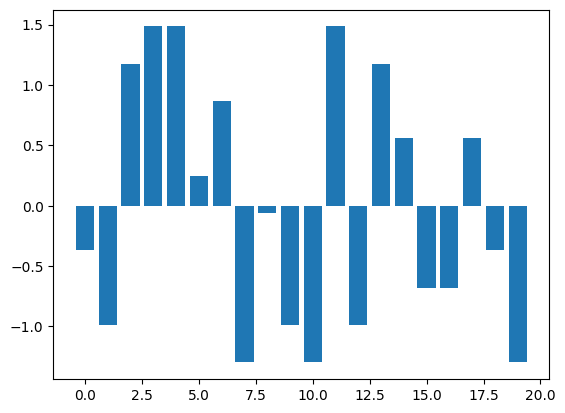

In [135]:
plt.bar(range(len(mean_vote[:20])), (np.array(mean_vote[:20]) - np.mean(mean_vote[:20]))/(np.std(mean_vote[:20])))

In [117]:
# find best cost param:
cost = 0.000085
mutual_information_median_split = [1 if datum > cost else 0 for datum in mutual_information][:N_DATA]

print("MI", mutual_information_median_split.count(1))
mi_agreement_combined, mean_mi_agreement_combined, n_mi_combined = calculate_agreement(mutual_information_median_split, pos_neg=None, maj_vote=maj_vote)
mi_agreement_answer_dir, mean_mi_agreement_answer_dir, n_mi_answer_dir = calculate_agreement(mutual_information_median_split, pos_neg=0, maj_vote=maj_vote)
mi_agreement_ask_question, mean_mi_agreement_ask_question, n_mi_ask_question = calculate_agreement(mutual_information_median_split, pos_neg=1, maj_vote=maj_vote)
print(mean_mi_agreement_combined, mean_mi_agreement_answer_dir, mean_mi_agreement_ask_question)

MI 66
124
0.75 0.8387096774193549 0.6052631578947368


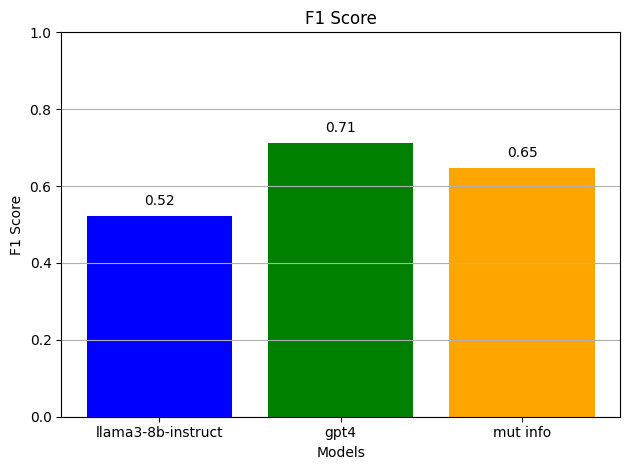

In [160]:
# Compute F1 scores for each model
llama_f1 = f1_score(maj_vote, llama_labels, average='binary')
gpt4_f1 = f1_score(maj_vote, gpt4_labels, average='binary')
mi_f1 = f1_score(maj_vote, mutual_information_median_split , average='binary')
# mi_f2 = f1_score(maj_vote, mutual_information_median_split , average='binary')

# Plotting
models = ['llama3-8b-instruct', 'gpt4', 'mut info']
f1_scores = [llama_f1, gpt4_f1, mi_f1, ]

fig, ax = plt.subplots()
ax.bar(models, f1_scores, color=['blue', 'green', 'orange', 'pink'])
ax.set_xlabel('Models')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score')
ax.set_ylim(0, 1)  # Setting y-axis limit from 0 to 1 for F1 score
ax.grid(axis='y')

# Adding text annotations with the exact F1 scores on top of each bar
for i, score in enumerate(f1_scores):
    ax.text(i, score + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

0.69
124
124
124


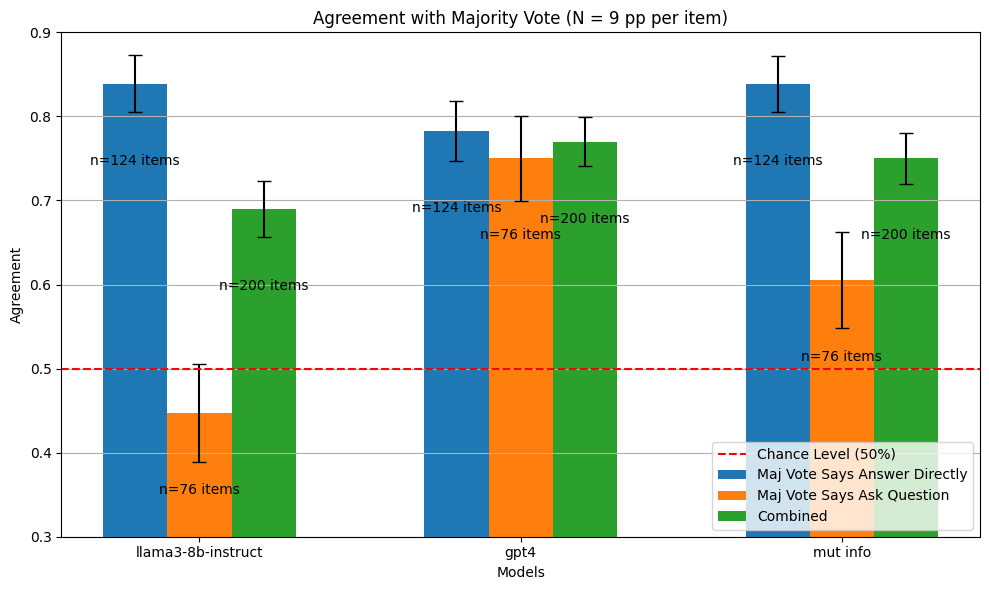

In [119]:
# Compute agreements for pos_neg == None, 0, and 1
llama_agreement_combined, mean_llama_agreement_combined, n_llama_combined = calculate_agreement(llama_labels, pos_neg=None, maj_vote=maj_vote)
gpt4_agreement_combined, mean_gpt4_agreement_combined, n_gpt4_combined = calculate_agreement(gpt4_labels, pos_neg=None, maj_vote=maj_vote)
mi_agreement_combined, mean_mi_agreement_combined, n_mi_combined = calculate_agreement(mutual_information_median_split, pos_neg=None, maj_vote=maj_vote)
print(mean_llama_agreement_combined)
llama_agreement_answer_dir, mean_llama_agreement_answer_dir, n_llama_answer_dir = calculate_agreement(llama_labels, pos_neg=0, maj_vote=maj_vote)
gpt4_agreement_answer_dir, mean_gpt4_agreement_answer_dir, n_gpt4_answer_dir = calculate_agreement(gpt4_labels, pos_neg=0, maj_vote=maj_vote)
mi_agreement_answer_dir, mean_mi_agreement_answer_dir, n_mi_answer_dir = calculate_agreement(mutual_information_median_split, pos_neg=0, maj_vote=maj_vote)

llama_agreement_ask_question, mean_llama_agreement_ask_question, n_llama_ask_question = calculate_agreement(llama_labels, pos_neg=1, maj_vote=maj_vote)
gpt4_agreement_ask_question, mean_gpt4_agreement_ask_question, n_gpt4_ask_question = calculate_agreement(gpt4_labels, pos_neg=1, maj_vote=maj_vote)
mi_agreement_ask_question, mean_mi_agreement_ask_question, n_mi_ask_question = calculate_agreement(mutual_information_median_split, pos_neg=1, maj_vote=maj_vote)

# Bootstrapped standard error calculation
llama_boot_se_combined = bootstrap_se(llama_agreement_combined)
gpt4_boot_se_combined = bootstrap_se(gpt4_agreement_combined)
mi_boot_se_combined = bootstrap_se(mi_agreement_combined)

llama_boot_se_answer_dir = bootstrap_se(llama_agreement_answer_dir)
gpt4_boot_se_answer_dir = bootstrap_se(gpt4_agreement_answer_dir)
mi_boot_se_answer_dir = bootstrap_se(mi_agreement_answer_dir)

llama_boot_se_ask_question = bootstrap_se(llama_agreement_ask_question)
gpt4_boot_se_ask_question = bootstrap_se(gpt4_agreement_ask_question)
mi_boot_se_ask_question = bootstrap_se(mi_agreement_ask_question)

# Plotting
models = ['llama3-8b-instruct', 'gpt4', 'mut info']
labels = ['Maj Vote Says Answer Directly', 'Maj Vote Says Ask Question', 'Combined']
agreements = [
    [mean_llama_agreement_answer_dir, mean_llama_agreement_ask_question, mean_llama_agreement_combined],
    [mean_gpt4_agreement_answer_dir, mean_gpt4_agreement_ask_question, mean_gpt4_agreement_combined],
    [mean_mi_agreement_answer_dir, mean_mi_agreement_ask_question, mean_mi_agreement_combined]
]
n_values = [
    [n_llama_answer_dir, n_llama_ask_question, n_llama_combined],
    [n_gpt4_answer_dir, n_gpt4_ask_question, n_gpt4_combined],
    [n_mi_answer_dir, n_mi_ask_question, n_mi_combined]
]
boot_se_values = [
    [llama_boot_se_answer_dir, llama_boot_se_ask_question, llama_boot_se_combined],
    [gpt4_boot_se_answer_dir, gpt4_boot_se_ask_question, gpt4_boot_se_combined],
    [mi_boot_se_answer_dir, mi_boot_se_ask_question, mi_boot_se_combined]
]

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(labels)):
    ax.bar(x + i * width - width, [agreements[j][i] for j in range(len(models))], width, label=labels[i], yerr=[boot_se_values[j][i] for j in range(len(models))], capsize=5)
    for j in range(len(models)):
        ax.text(x[j] + i * width - width, agreements[j][i] - 0.1, f'n={n_values[j][i]} items', ha='center', va='bottom')

ax.axhline(y=0.5, color='r', linestyle='--', label='Chance Level (50%)')
ax.set_xlabel('Models')
ax.set_ylabel('Agreement')
ax.set_title('Agreement with Majority Vote (N = 9 pp per item)')
ax.set_xticks(x)
ax.set_ylim(.3, .9)
ax.grid(axis='y')
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()


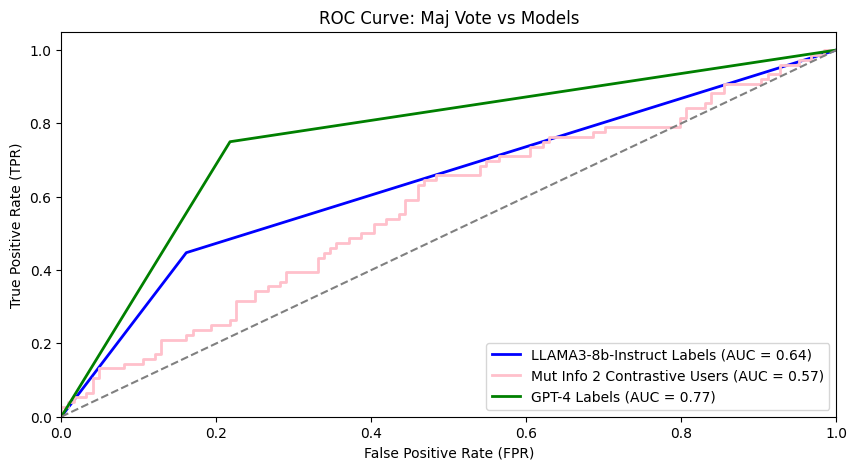

In [120]:
# Compute ROC curves f
fpr_llama, tpr_llama, roc_auc_llama = compute_roc_auc(maj_vote, llama_labels)
fpr_gpt4, tpr_gpt4, roc_auc_gpt4 = compute_roc_auc(maj_vote, gpt4_labels)
fpr_mi_2, tpr_mi_2, roc_auc_mi_2 = compute_roc_auc(maj_vote, mutual_information_2[:N_DATA])
# fpr_eig_2, tpr_eig_2, roc_auc_eig_2 = compute_roc_auc(maj_vote, eig[:N_DATA])
# Plot ROC curves
plt.figure(figsize=(10, 5))
plt.plot(fpr_llama, tpr_llama, color='blue', lw=2, label=f'LLAMA3-8b-Instruct Labels (AUC = {roc_auc_llama:.2f})')
plt.plot(fpr_mi_2, tpr_mi_2, color='pink', lw=2, label=f'Mut Info 2 Contrastive Users (AUC = {roc_auc_mi_2:.2f})')
# plt.plot(fpr_mi_3, tpr_mi_3, color='orange', lw=2, label=f'Mut Info 3 Users (AUC = {roc_auc_mi_3:.2f})')
# plt.plot(fpr_mi_4, tpr_mi_4, color='black', lw=2, label=f'Mut Info 4 Users (AUC = {roc_auc_mi_4:.2f})')
plt.plot(fpr_gpt4, tpr_gpt4, color='green', lw=2, label=f'GPT-4 Labels (AUC = {roc_auc_gpt4:.2f})')
# plt.plot(fpr_eig_2, tpr_eig_2, color='green', lw=2, label=f'EIG (AUC = {roc_auc_eig_2:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve: Maj Vote vs Models')
plt.legend(loc="lower right")
plt.show()

In [121]:
# Load behavior data 
llama38b_behavior = json.load(open('results/base_questions_user_21_max_words_25_full_sentence.json'))
stargate_epoch_1 = json.load(open('results/no_cot_ckpt_1_questions_user_21_max_words_25_full_sentence_lr_1e-5.json'))
stargate_epoch_2 = json.load(open('results/no_cot_ckpt_2_questions_user_21_max_words_25_full_sentence_lr_1e-5.json'))


stargate_epoch_1_cot = json.load(open('results/cot_ckpt_1_questions_user_21_max_words_25_full_sentence_lr_1e-5.json'))
stargate_epoch_2_cot = json.load(open('results/cot_ckpt_2_questions_user_21_max_words_25_full_sentence_lr_1e-5.json'))


/tmp/user/22820/ipykernel_3732109/1088763006.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)


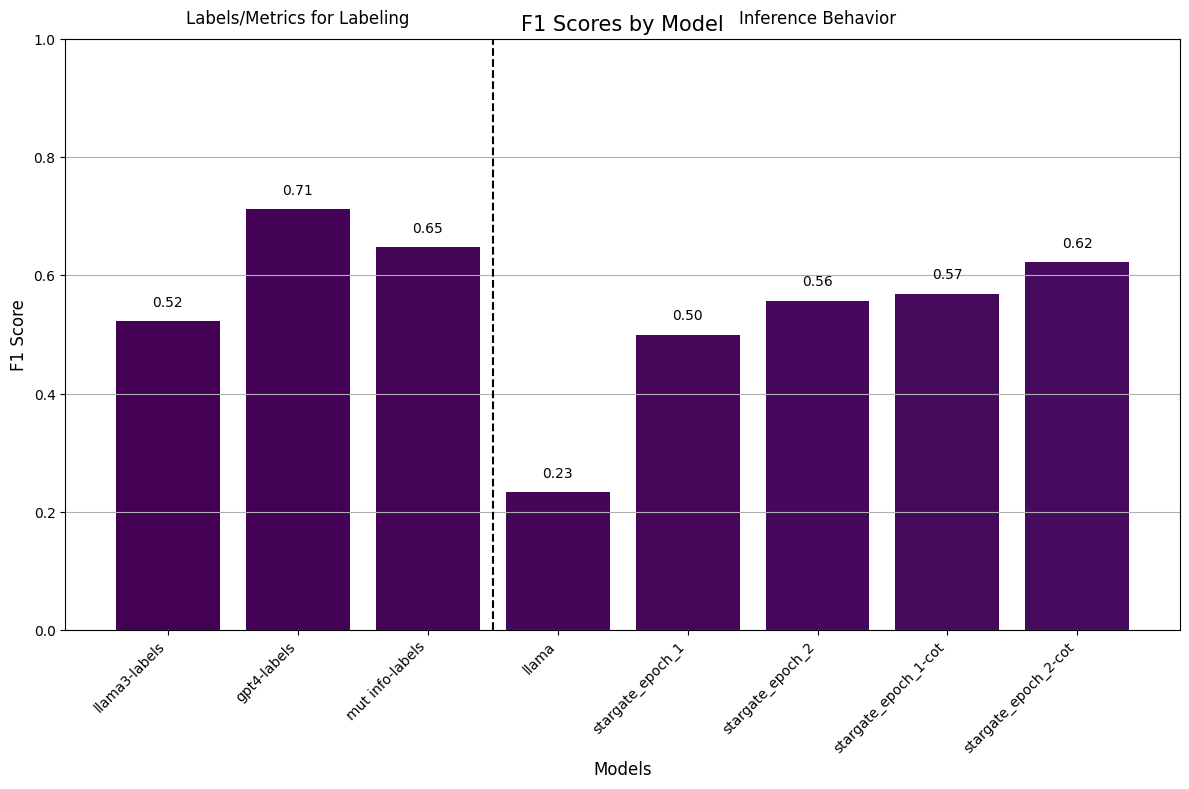

In [122]:
# Compute F1 scores for each model
llama_lf = f1_score(maj_vote, llama_labels, average='binary')
gpt4_f1 = f1_score(maj_vote, gpt4_labels, average='binary')
mi = f1_score(maj_vote, mutual_information_median_split, average='binary')

llama_f1 = f1_score(maj_vote, llama38b_behavior, average='binary')
stargate_f1_epoch_1 = f1_score(maj_vote, stargate_epoch_1, average='binary')
stargate_f1_epoch_2 = f1_score(maj_vote, stargate_epoch_2, average='binary')
stargate_f1_epoch_1_cot = f1_score(maj_vote, stargate_epoch_1_cot , average='binary')
stargate_f1_epoch_2_cot = f1_score(maj_vote, stargate_epoch_2_cot, average='binary')

# Plotting
models = ['llama3-labels', 'gpt4-labels', 'mut info-labels', 'llama', 'stargate_epoch_1', 'stargate_epoch_2', 'stargate_epoch_1-cot', 'stargate_epoch_2-cot']
f1_scores = [llama_lf, gpt4_f1, mi, llama_f1, stargate_f1_epoch_1, stargate_f1_epoch_2, stargate_f1_epoch_1_cot, stargate_f1_epoch_2_cot]

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(models, f1_scores, color=plt.cm.viridis(range(len(models))))

# Adding the vertical bar and labels
plt.axvline(x=2.5, color='black', linestyle='--')
ax.text(1, 1.02, 'Labels/Metrics for Labeling', ha='center', va='bottom', fontsize=12)
ax.text(5, 1.02, 'Inference Behavior', ha='center', va='bottom', fontsize=12)

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 Scores by Model', fontsize=15)
ax.set_ylim(0, 1)  # Setting y-axis limit from 0 to 1 for F1 score
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
ax.grid(axis='y')

# Adding text annotations with the exact F1 scores on top of each bar
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

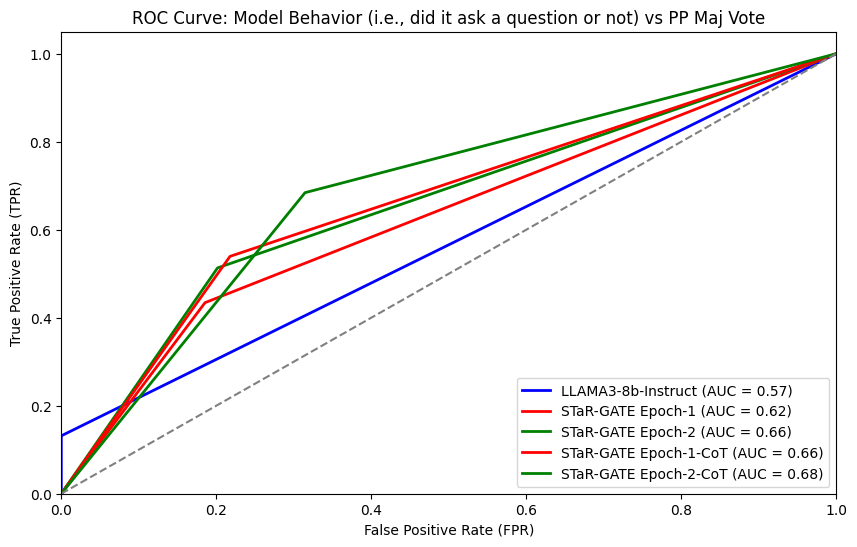

In [123]:


# Compute ROC AUC
fpr_llama, tpr_llama, roc_auc_llama = compute_roc_auc(maj_vote, llama38b_behavior)
fpr_epoch_1_no_cot, tpr_epoch_1_no_cot, roc_auc_epoch_1_no_cot = compute_roc_auc(maj_vote, stargate_epoch_1)
fpr_epoch_2_no_cot, tpr_epoch_2_no_cot, roc_auc_epoch_2_no_cot = compute_roc_auc(maj_vote, stargate_epoch_2)
fpr_epoch_1, tpr_epoch_1, roc_auc_epoch_1 = compute_roc_auc(maj_vote, stargate_epoch_1_cot)
fpr_epoch_2, tpr_epoch_2, roc_auc_epoch_2 = compute_roc_auc(maj_vote, stargate_epoch_2_cot)


# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_llama, tpr_llama, color='blue', lw=2, label=f'LLAMA3-8b-Instruct (AUC = {roc_auc_llama:.2f})')
plt.plot(fpr_epoch_1_no_cot, tpr_epoch_1_no_cot, color='red', lw=2, label=f'STaR-GATE Epoch-1 (AUC = {roc_auc_epoch_1_no_cot:.2f})')
plt.plot(fpr_epoch_2_no_cot, tpr_epoch_2_no_cot, color='green', lw=2, label=f'STaR-GATE Epoch-2 (AUC = {roc_auc_epoch_2_no_cot:.2f})')
plt.plot(fpr_epoch_1, tpr_epoch_1, color='red', lw=2, label=f'STaR-GATE Epoch-1-CoT (AUC = {roc_auc_epoch_1:.2f})')
plt.plot(fpr_epoch_2, tpr_epoch_2, color='green', lw=2, label=f'STaR-GATE Epoch-2-CoT (AUC = {roc_auc_epoch_2:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve: Model Behavior (i.e., did it ask a question or not) vs PP Maj Vote')
plt.legend(loc="lower right")
plt.show()


[0.7678571428571429, 0.4965277777777778, 0.5725] [0.75, 0.4742647058823529, 0.5625]


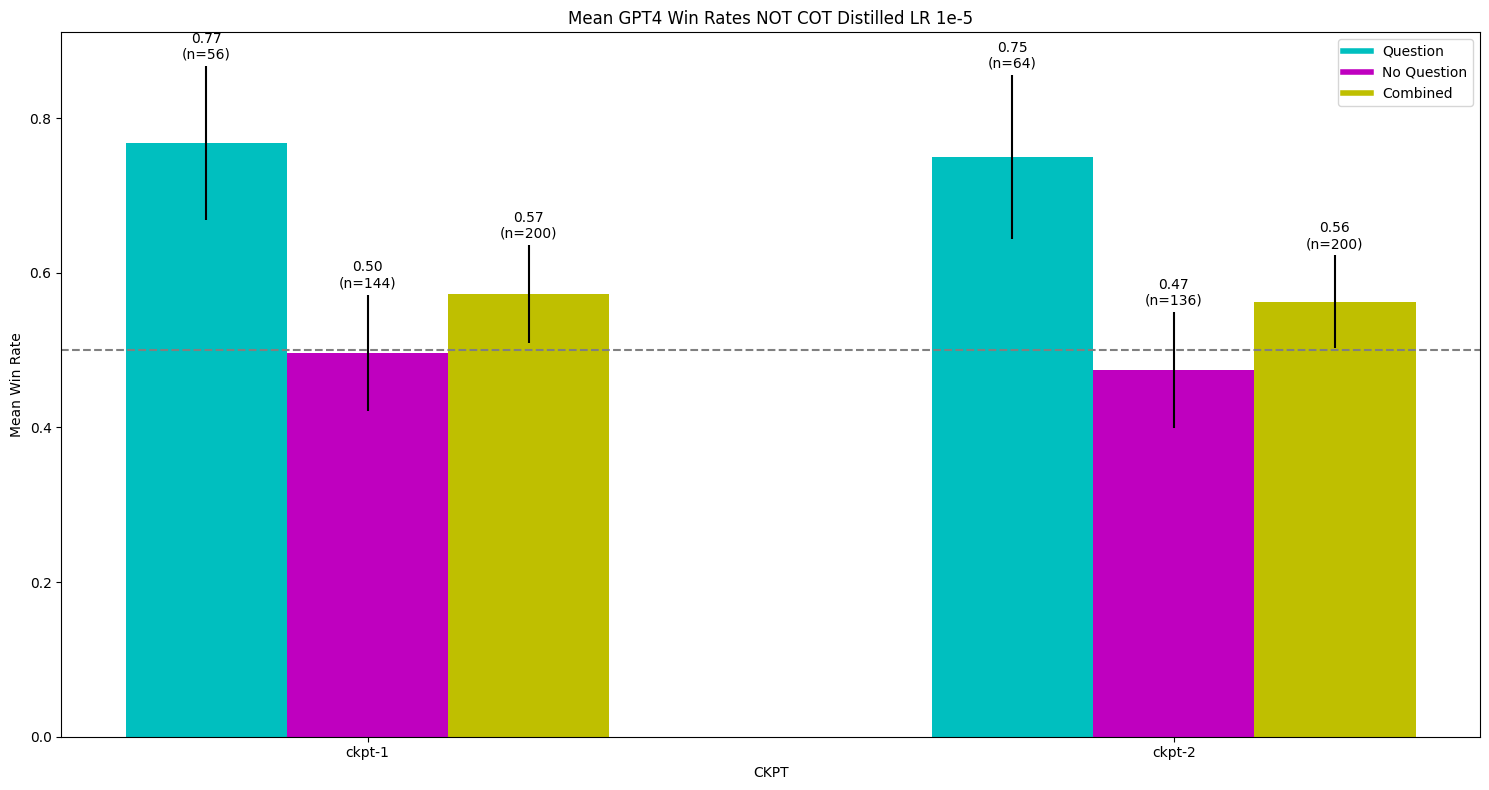

In [124]:
# Load win rates data
stargate_epoch_1_no_cot = json.load(open("results/no_cot_ckpt_1_questions_user_21_max_words_25_full_sentence_lr_1e-5.json", "r"))
win_rates_no_cot_1 = json.load(open("results/no_cot_ckpt_1_win_rates_user_21_max_words_25_full_sentence_lr_1e-5.json", "r"))
win_rates_no_cot_1_q = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 1]
win_rates_no_cot_1_nq = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 0]


stargate_epoch_1_cot = json.load(open("results/no_cot_ckpt_2_questions_user_21_max_words_25_full_sentence_lr_1e-5.json", "r"))
win_rates_cot_1 = json.load(open("results/no_cot_ckpt_2_win_rates_user_21_max_words_25_full_sentence_lr_1e-5.json", "r"))
win_rates_cot_1_q = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 1]
win_rates_cot_1_nq = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 0]

# Calculate means and CIs
epochs = ['ckpt-1', 'ckpt-2']
win_rates_no_cot_q = [win_rates_no_cot_1_q, win_rates_no_cot_1_nq, win_rates_no_cot_1]
win_rates_cot_q = [win_rates_cot_1_q, win_rates_cot_1_nq, win_rates_cot_1]

mean_no_cot = [np.mean(win_rate) for win_rate in win_rates_no_cot_q]
mean_cot = [np.mean(win_rate) for win_rate in win_rates_cot_q]
print(mean_no_cot, mean_cot)

ci_no_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_no_cot_q]
ci_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_cot_q]

lens_no_cot = [len(win_rates_no_cot_1_q), len(win_rates_no_cot_1_nq), len(win_rates_no_cot_1)]
lens_cot = [len(win_rates_cot_1_q), len(win_rates_cot_1_nq), len(win_rates_cot_1)]

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

bar_width = 0.2
index = np.arange(len(epochs))

# Define colors for the bars
colors = ['c', 'm', 'y']
labels = ['Question', 'No Question', 'Combined']

# Plot bars for mean_no_cot
for i, (mean, ci, length) in enumerate(zip(mean_no_cot, ci_no_cot, lens_no_cot)):
    bar = ax.bar(index[0] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Plot bars for mean_cot
for i, (mean, ci, length) in enumerate(zip(mean_cot, ci_cot, lens_cot)):
    bar = ax.bar(index[1] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Add labels and title
ax.set_xlabel('CKPT')
ax.set_ylabel('Mean Win Rate')
ax.set_title('Mean GPT4 Win Rates NOT COT Distilled LR 1e-5')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(epochs)

# Create a custom legend
custom_legend = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
ax.legend(custom_legend, labels)

# Add vertical line at 0.5 to represent chance
ax.axhline(y=0.5, color='grey', linestyle='--')

# Show plot
plt.tight_layout()
plt.show()

[0.7358490566037735, 0.48639455782312924, 0.5525] [0.7272727272727273, 0.5448275862068965, 0.595]


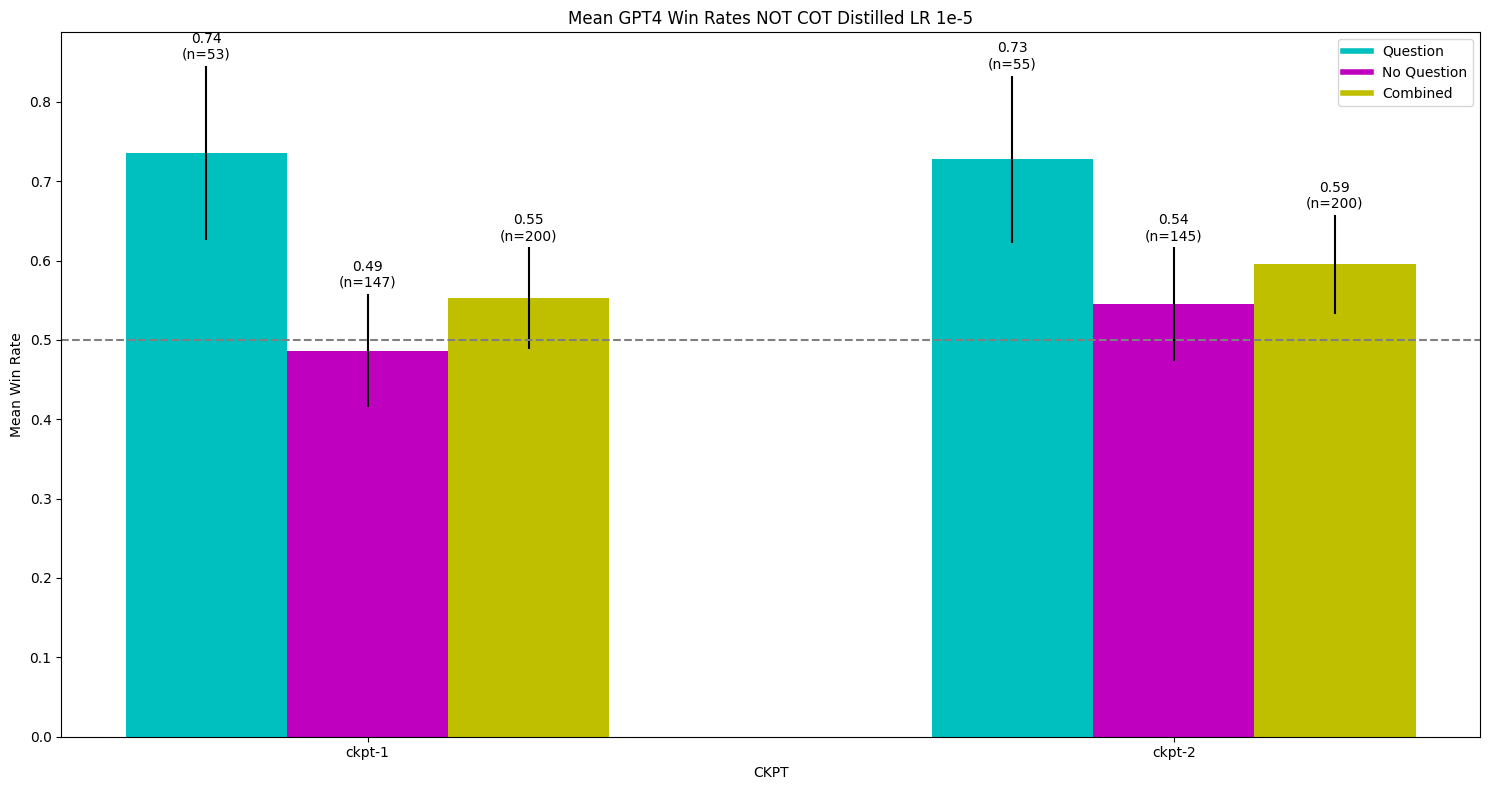

In [125]:
# Load win rates data
stargate_epoch_1_no_cot = json.load(open("results/no_cot_ckpt_1_questions_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_no_cot_1 = json.load(open("results/no_cot_ckpt_1_win_rates_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_no_cot_1_q = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 1]
win_rates_no_cot_1_nq = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 0]


stargate_epoch_1_cot = json.load(open("results/no_cot_ckpt_2_questions_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_cot_1 = json.load(open("results/no_cot_ckpt_2_win_rates_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_cot_1_q = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 1]
win_rates_cot_1_nq = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 0]

# Calculate means and CIs
epochs = ['ckpt-1', 'ckpt-2']
win_rates_no_cot_q = [win_rates_no_cot_1_q, win_rates_no_cot_1_nq, win_rates_no_cot_1]
win_rates_cot_q = [win_rates_cot_1_q, win_rates_cot_1_nq, win_rates_cot_1]

mean_no_cot = [np.mean(win_rate) for win_rate in win_rates_no_cot_q]
mean_cot = [np.mean(win_rate) for win_rate in win_rates_cot_q]
print(mean_no_cot, mean_cot)

ci_no_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_no_cot_q]
ci_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_cot_q]

lens_no_cot = [len(win_rates_no_cot_1_q), len(win_rates_no_cot_1_nq), len(win_rates_no_cot_1)]
lens_cot = [len(win_rates_cot_1_q), len(win_rates_cot_1_nq), len(win_rates_cot_1)]

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

bar_width = 0.2
index = np.arange(len(epochs))

# Define colors for the bars
colors = ['c', 'm', 'y']
labels = ['Question', 'No Question', 'Combined']

# Plot bars for mean_no_cot
for i, (mean, ci, length) in enumerate(zip(mean_no_cot, ci_no_cot, lens_no_cot)):
    bar = ax.bar(index[0] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Plot bars for mean_cot
for i, (mean, ci, length) in enumerate(zip(mean_cot, ci_cot, lens_cot)):
    bar = ax.bar(index[1] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Add labels and title
ax.set_xlabel('CKPT')
ax.set_ylabel('Mean Win Rate')
ax.set_title('Mean GPT4 Win Rates NOT COT Distilled LR 1e-5')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(epochs)

# Create a custom legend
custom_legend = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
ax.legend(custom_legend, labels)

# Add vertical line at 0.5 to represent chance
ax.axhline(y=0.5, color='grey', linestyle='--')

# Show plot
plt.tight_layout()
plt.show()

[0.47058823529411764, 0.5227272727272727, 0.505] [0.6263736263736264, 0.4541284403669725, 0.5325]


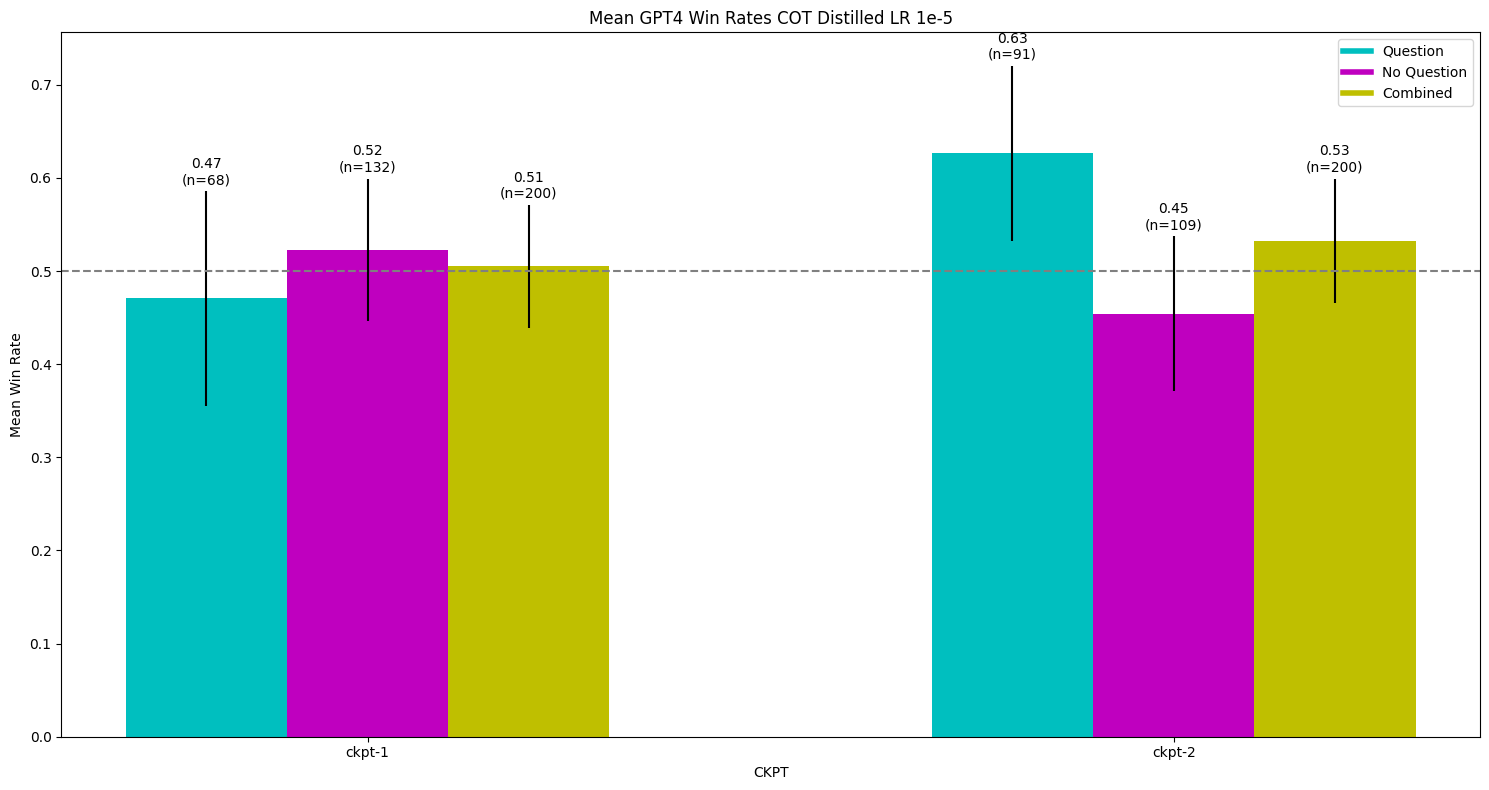

In [126]:
# Load win rates data
stargate_epoch_1_no_cot = json.load(open("results/cot_ckpt_1_questions_user_21_max_words_25_full_sentence_lr_1e-5.json", "r"))
win_rates_no_cot_1 = json.load(open("results/cot_ckpt_1_win_rates_user_21_max_words_25_full_sentence_lr_1e-5.json", "r"))
win_rates_no_cot_1_q = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 1]
win_rates_no_cot_1_nq = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 0]


stargate_epoch_1_cot = json.load(open("results/cot_ckpt_2_questions_user_21_max_words_25_full_sentence_lr_1e-5.json", "r"))
win_rates_cot_1 = json.load(open("results/cot_ckpt_2_win_rates_user_21_max_words_25_full_sentence_lr_1e-5.json", "r"))
win_rates_cot_1_q = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 1]
win_rates_cot_1_nq = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 0]

# Calculate means and CIs
epochs = ['ckpt-1', 'ckpt-2']
win_rates_no_cot_q = [win_rates_no_cot_1_q, win_rates_no_cot_1_nq, win_rates_no_cot_1]
win_rates_cot_q = [win_rates_cot_1_q, win_rates_cot_1_nq, win_rates_cot_1]

mean_no_cot = [np.mean(win_rate) for win_rate in win_rates_no_cot_q]
mean_cot = [np.mean(win_rate) for win_rate in win_rates_cot_q]
print(mean_no_cot, mean_cot)

ci_no_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_no_cot_q]
ci_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_cot_q]

lens_no_cot = [len(win_rates_no_cot_1_q), len(win_rates_no_cot_1_nq), len(win_rates_no_cot_1)]
lens_cot = [len(win_rates_cot_1_q), len(win_rates_cot_1_nq), len(win_rates_cot_1)]

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

bar_width = 0.2
index = np.arange(len(epochs))

# Define colors for the bars
colors = ['c', 'm', 'y']
labels = ['Question', 'No Question', 'Combined']

# Plot bars for mean_no_cot
for i, (mean, ci, length) in enumerate(zip(mean_no_cot, ci_no_cot, lens_no_cot)):
    bar = ax.bar(index[0] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Plot bars for mean_cot
for i, (mean, ci, length) in enumerate(zip(mean_cot, ci_cot, lens_cot)):
    bar = ax.bar(index[1] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Add labels and title
ax.set_xlabel('CKPT')
ax.set_ylabel('Mean Win Rate')
ax.set_title('Mean GPT4 Win Rates COT Distilled LR 1e-5')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(epochs)

# Create a custom legend
custom_legend = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
ax.legend(custom_legend, labels)

# Add vertical line at 0.5 to represent chance
ax.axhline(y=0.5, color='grey', linestyle='--')

# Show plot
plt.tight_layout()
plt.show()

[0.9264705882352942, 0.4583333333333333, 0.6175] [0.8681318681318682, 0.536697247706422, 0.6875]


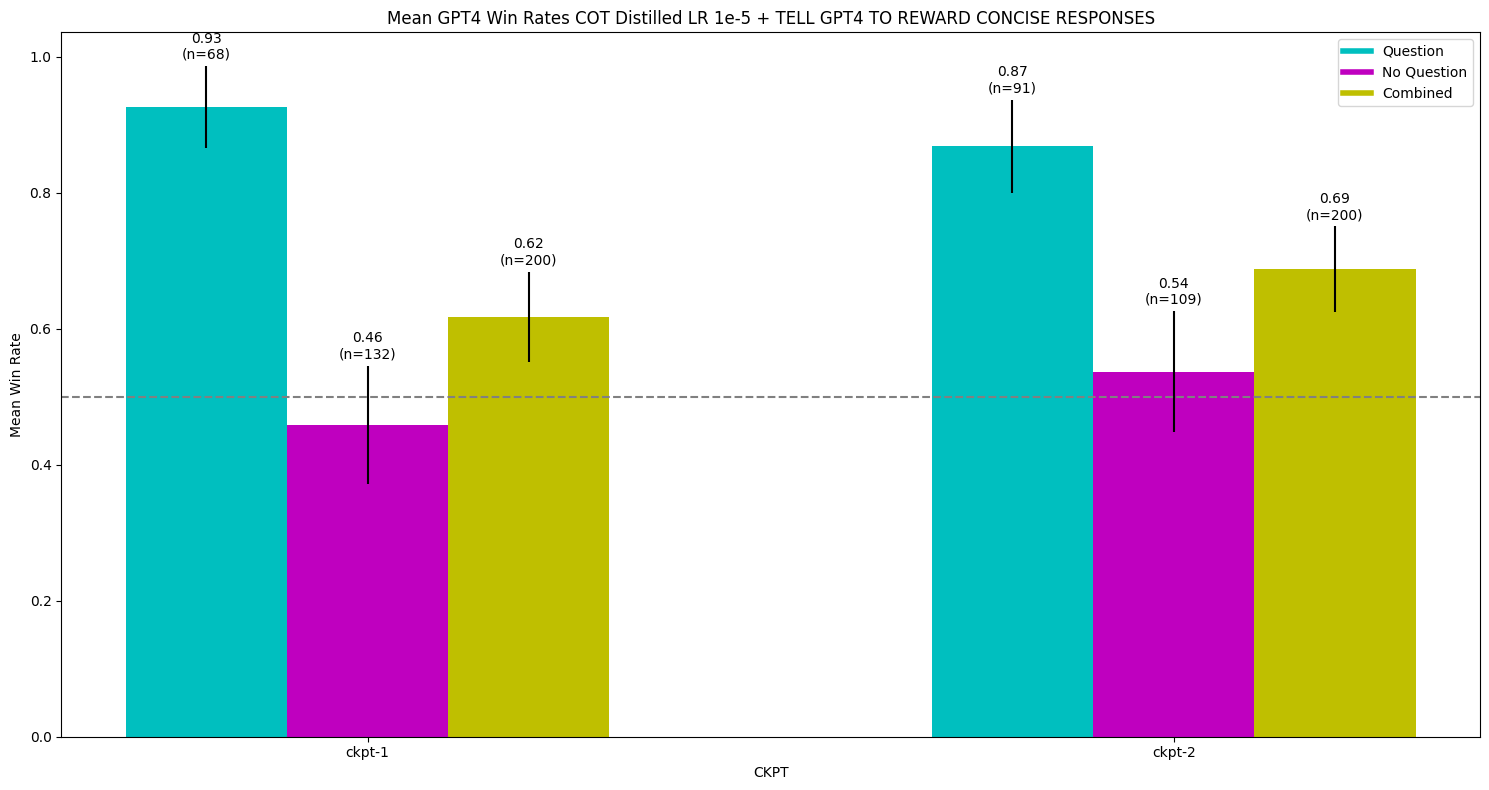

In [127]:
# Load win rates data
stargate_epoch_1_no_cot = json.load(open("results/cot_ckpt_1_questions_user_21_max_words_25_full_sentence_lr_1e-5.json", "r"))
win_rates_no_cot_1 = json.load(open("results/cot_ckpt_1_win_rates_user_21_max_words_25_full_sentence_lr_1e-5_short.json", "r"))
win_rates_no_cot_1_q = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 1]
win_rates_no_cot_1_nq = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 0]


stargate_epoch_1_cot = json.load(open("results/cot_ckpt_2_questions_user_21_max_words_25_full_sentence_lr_1e-5.json", "r"))
win_rates_cot_1 = json.load(open("results/cot_ckpt_2_win_rates_user_21_max_words_25_full_sentence_lr_1e-5_short.json", "r"))
win_rates_cot_1_q = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 1]
win_rates_cot_1_nq = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 0]

# Calculate means and CIs
epochs = ['ckpt-1', 'ckpt-2']
win_rates_no_cot_q = [win_rates_no_cot_1_q, win_rates_no_cot_1_nq, win_rates_no_cot_1]
win_rates_cot_q = [win_rates_cot_1_q, win_rates_cot_1_nq, win_rates_cot_1]

mean_no_cot = [np.mean(win_rate) for win_rate in win_rates_no_cot_q]
mean_cot = [np.mean(win_rate) for win_rate in win_rates_cot_q]
print(mean_no_cot, mean_cot)

ci_no_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_no_cot_q]
ci_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_cot_q]

lens_no_cot = [len(win_rates_no_cot_1_q), len(win_rates_no_cot_1_nq), len(win_rates_no_cot_1)]
lens_cot = [len(win_rates_cot_1_q), len(win_rates_cot_1_nq), len(win_rates_cot_1)]

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

bar_width = 0.2
index = np.arange(len(epochs))

# Define colors for the bars
colors = ['c', 'm', 'y']
labels = ['Question', 'No Question', 'Combined']

# Plot bars for mean_no_cot
for i, (mean, ci, length) in enumerate(zip(mean_no_cot, ci_no_cot, lens_no_cot)):
    bar = ax.bar(index[0] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Plot bars for mean_cot
for i, (mean, ci, length) in enumerate(zip(mean_cot, ci_cot, lens_cot)):
    bar = ax.bar(index[1] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Add labels and title
ax.set_xlabel('CKPT')
ax.set_ylabel('Mean Win Rate')
ax.set_title('Mean GPT4 Win Rates COT Distilled LR 1e-5 + TELL GPT4 TO REWARD CONCISE RESPONSES')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(epochs)

# Create a custom legend
custom_legend = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
ax.legend(custom_legend, labels)

# Add vertical line at 0.5 to represent chance
ax.axhline(y=0.5, color='grey', linestyle='--')

# Show plot
plt.tight_layout()
plt.show()

[0.4485294117647059, 0.49242424242424243, 0.4775] [0.5, 0.5, 0.5]


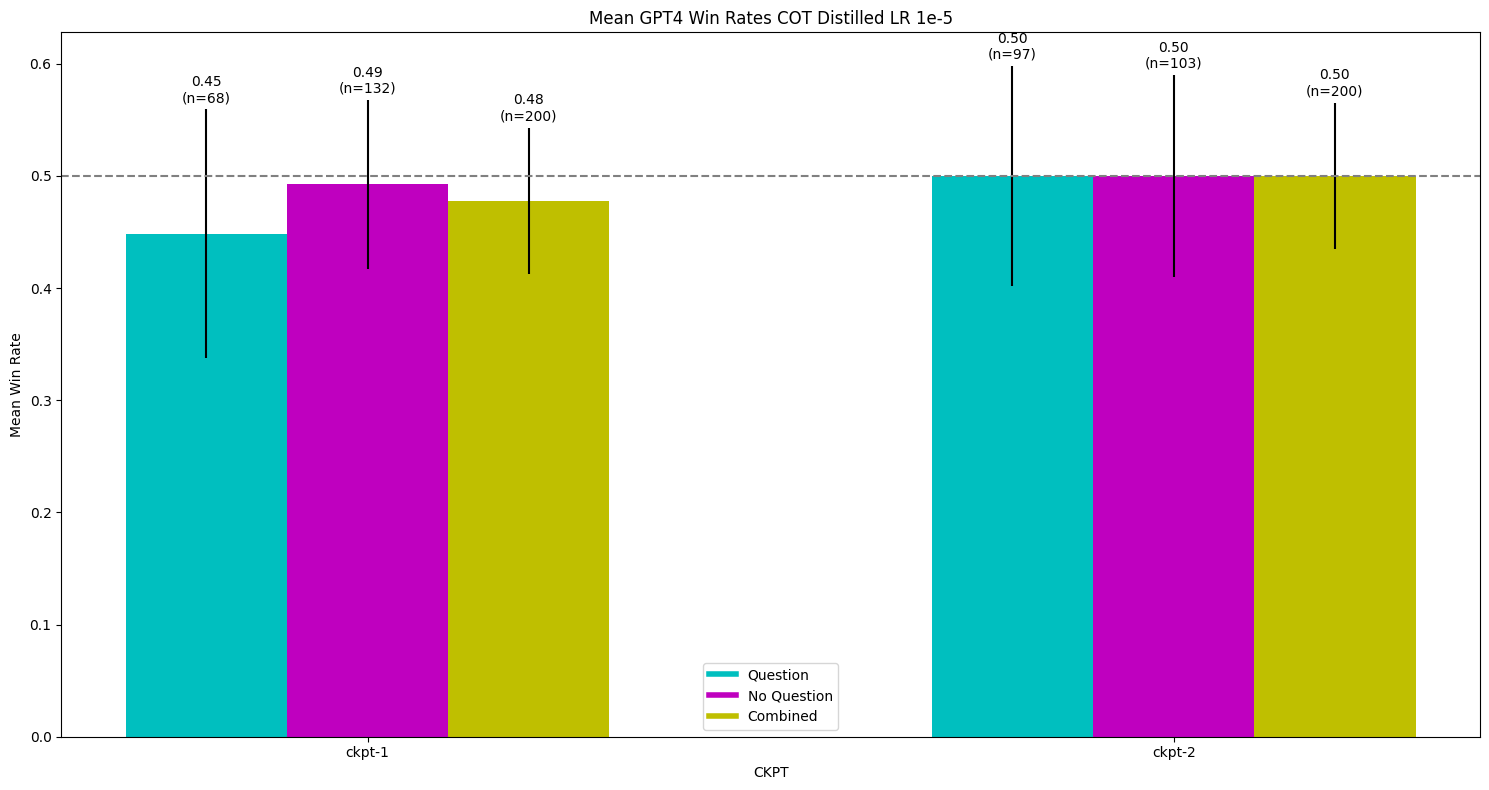

In [128]:
# ONE USER 
# Load win rates data
stargate_epoch_1_no_cot = json.load(open("results/cot_ckpt_1_questions_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_no_cot_1 = json.load(open("results/cot_ckpt_1_win_rates_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_no_cot_1_q = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 1]
win_rates_no_cot_1_nq = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 0]


stargate_epoch_1_cot = json.load(open("results/cot_ckpt_2_questions_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_cot_1 = json.load(open("results/cot_ckpt_2_win_rates_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_cot_1_q = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 1]
win_rates_cot_1_nq = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 0]

# Calculate means and CIs
epochs = ['ckpt-1', 'ckpt-2']
win_rates_no_cot_q = [win_rates_no_cot_1_q, win_rates_no_cot_1_nq, win_rates_no_cot_1]
win_rates_cot_q = [win_rates_cot_1_q, win_rates_cot_1_nq, win_rates_cot_1]

mean_no_cot = [np.mean(win_rate) for win_rate in win_rates_no_cot_q]
mean_cot = [np.mean(win_rate) for win_rate in win_rates_cot_q]
print(mean_no_cot, mean_cot)

ci_no_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_no_cot_q]
ci_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_cot_q]

lens_no_cot = [len(win_rates_no_cot_1_q), len(win_rates_no_cot_1_nq), len(win_rates_no_cot_1)]
lens_cot = [len(win_rates_cot_1_q), len(win_rates_cot_1_nq), len(win_rates_cot_1)]

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

bar_width = 0.2
index = np.arange(len(epochs))

# Define colors for the bars
colors = ['c', 'm', 'y']
labels = ['Question', 'No Question', 'Combined']

# Plot bars for mean_no_cot
for i, (mean, ci, length) in enumerate(zip(mean_no_cot, ci_no_cot, lens_no_cot)):
    bar = ax.bar(index[0] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Plot bars for mean_cot
for i, (mean, ci, length) in enumerate(zip(mean_cot, ci_cot, lens_cot)):
    bar = ax.bar(index[1] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Add labels and title
ax.set_xlabel('CKPT')
ax.set_ylabel('Mean Win Rate')
ax.set_title('Mean GPT4 Win Rates COT Distilled LR 1e-5')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(epochs)

# Create a custom legend
custom_legend = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
ax.legend(custom_legend, labels)

# Add vertical line at 0.5 to represent chance
ax.axhline(y=0.5, color='grey', linestyle='--')

# Show plot
plt.tight_layout()
plt.show()

[0.8676470588235294, 0.4696969696969697, 0.605] [0.8556701030927835, 0.5048543689320388, 0.675]


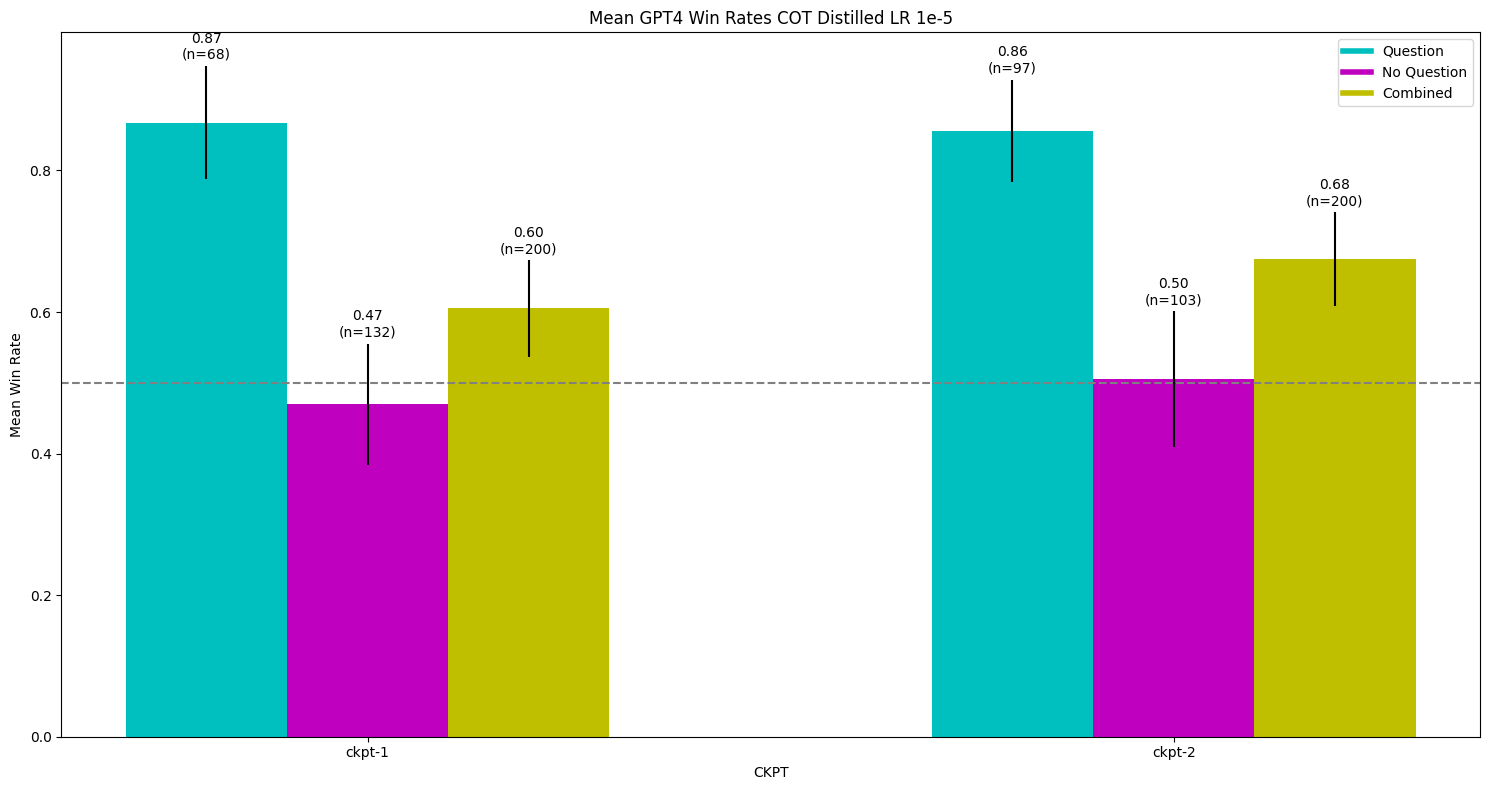

In [129]:
# ONE USER 
# Load win rates data
stargate_epoch_1_no_cot = json.load(open("results/cot_ckpt_1_questions_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_no_cot_1 = json.load(open("results/cot_ckpt_1_win_rates_user_21_max_words_25_full_sentence_lr_1e-5_one_user_short.json", "r"))
win_rates_no_cot_1_q = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 1]
win_rates_no_cot_1_nq = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 0]


stargate_epoch_1_cot = json.load(open("results/cot_ckpt_2_questions_user_21_max_words_25_full_sentence_lr_1e-5_one_user.json", "r"))
win_rates_cot_1 = json.load(open("results/cot_ckpt_2_win_rates_user_21_max_words_25_full_sentence_lr_1e-5_one_user_short.json", "r"))
win_rates_cot_1_q = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 1]
win_rates_cot_1_nq = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1_cot) if q == 0]

# Calculate means and CIs
epochs = ['ckpt-1', 'ckpt-2']
win_rates_no_cot_q = [win_rates_no_cot_1_q, win_rates_no_cot_1_nq, win_rates_no_cot_1]
win_rates_cot_q = [win_rates_cot_1_q, win_rates_cot_1_nq, win_rates_cot_1]

mean_no_cot = [np.mean(win_rate) for win_rate in win_rates_no_cot_q]
mean_cot = [np.mean(win_rate) for win_rate in win_rates_cot_q]
print(mean_no_cot, mean_cot)

ci_no_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_no_cot_q]
ci_cot = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_cot_q]

lens_no_cot = [len(win_rates_no_cot_1_q), len(win_rates_no_cot_1_nq), len(win_rates_no_cot_1)]
lens_cot = [len(win_rates_cot_1_q), len(win_rates_cot_1_nq), len(win_rates_cot_1)]

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

bar_width = 0.2
index = np.arange(len(epochs))

# Define colors for the bars
colors = ['c', 'm', 'y']
labels = ['Question', 'No Question', 'Combined']

# Plot bars for mean_no_cot
for i, (mean, ci, length) in enumerate(zip(mean_no_cot, ci_no_cot, lens_no_cot)):
    bar = ax.bar(index[0] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Plot bars for mean_cot
for i, (mean, ci, length) in enumerate(zip(mean_cot, ci_cot, lens_cot)):
    bar = ax.bar(index[1] + i * bar_width, mean, bar_width, yerr=ci, color=colors[i])
    ax.bar_label(bar, labels=[f'{mean:.2f}\n(n={length})'], padding=3)

# Add labels and title
ax.set_xlabel('CKPT')
ax.set_ylabel('Mean Win Rate')
ax.set_title('Mean GPT4 Win Rates COT Distilled LR 1e-5')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(epochs)

# Create a custom legend
custom_legend = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
ax.legend(custom_legend, labels)

# Add vertical line at 0.5 to represent chance
ax.axhline(y=0.5, color='grey', linestyle='--')

# Show plot
plt.tight_layout()
plt.show()